# Pickup to Delivery Overall

In [1]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import csv
import pickle
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.metrics.pairwise import haversine_distances, manhattan_distances
from sklearn.model_selection import train_test_split, cross_val_score

sys.path.insert(0, os.path.expanduser('./'))
import query_runner as qr
import utils

In [2]:
base_query_path = './queries/'
dwh_config, livedb_config, parameters_config = utils.load_config(config_file='./config.ini')
datalake_connection = qr.create_connection(db='datalake')
#monolith_connection = qr.create_connection(user=livedb_config['monolith_username'], password=livedb_config['monolith_password'], db='livedb')
#dispatching_db_connection = qr.create_connection(user=livedb_config['dispatching_db_username'], password=livedb_config['dispatching_db_password'], db='dispatchingdb')

In [3]:
start_date = parameters_config['start_date']
end_date = parameters_config['end_date']
country_code = parameters_config['country_code']
cities = parameters_config['cities']

print(f'Start date: {start_date} | End date: {end_date} | Countries: {country_code} | Cities: {cities}')

Start date: 2024-09-30 | End date: 2024-10-20 | Countries: ES | Cities: 'MAD', 'BCN', 'SEV', 'ALC'


In [4]:
parameters = {
    'start_date': start_date,
    'end_date': end_date,
    'country_code': country_code,
    'cities': cities
}

## Load the data

In [5]:
query_name = '''
SELECT
    olf.country_code                                 AS country_code,
    olf.city_code                                    AS city_code,
    olf.order_id                                     AS order_id,
    olf.courier_id                                   AS courier_id,
    olf.order_created_local_datetime                 AS creation_timestamp,
    olf.order_activated_local_datetime               AS activation_timestamp,
    olf.courier_transport                            AS transport,
    olf.order_picked_up_local_datetime               AS pickup_timestamp,
    olf.order_delivered_local_datetime               AS delivery_timestamp,
    olf.order_pickup_latitude                        AS pickup_latitude,
    olf.order_pickup_longitude                       AS pickup_longitude,
    olf.order_delivery_latitude                      AS delivery_latitude,
    olf.order_delivery_longitude                     AS delivery_longitude,
    olf.order_arrival_to_delivery_local_datetime     AS delivery_entering_timestamp,
    olf.order_time_zone                              AS time_zone,
    olf.p_creation_date
FROM delta.courier_routing_courier_ml_features_odp.order_level_features AS olf
WHERE order_final_status = 'DeliveredStatus'
    AND order_number_of_assignments = 1
    AND order_bundle_index IS NULL
    AND p_creation_date >= DATE '[start_date]' AND p_creation_date < DATE '[end_date]'
    AND country_code IN ('[country_code]')
    AND city_code IN ([cities])
'''

query = qr.Query(base_query_path, query_name, datalake_connection, parameters_dict=parameters, query_from_file = False)

df = query.run()
df = df.fillna(value=np.nan)

data = df.copy()
data.head()

Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/26578b11012706ca1c9e26727310675e872c61c059273c78d95c40bd00850af2


,country_code,city_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_timestamp,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude,delivery_entering_timestamp,time_zone,p_creation_date
0,ES,BCN,100907487116,8590944,2024-10-03 20:55:02+00:00,2024-10-03 20:55:04+00:00,BICYCLE,2024-10-03 21:21:44.215000+00:00,2024-10-03 21:32:33+00:00,41.370594,2.113433,41.375412,2.104837,2024-10-03 21:29:37+00:00,Europe/Madrid,2024-10-03
1,ES,MAD,100907489425,162535288,2024-10-03 20:55:43+00:00,2024-10-03 20:55:44+00:00,BICYCLE,2024-10-03 21:07:40.941000+00:00,2024-10-03 21:19:10+00:00,40.382927,-3.626392,40.383490,-3.640969,2024-10-03 21:16:09+00:00,Europe/Madrid,2024-10-03
2,ES,BCN,100907493124,146788593,2024-10-03 20:56:48+00:00,2024-10-03 20:56:49+00:00,BICYCLE,2024-10-03 21:07:40.560000+00:00,2024-10-03 21:14:30+00:00,41.389874,2.159761,41.390520,2.148718,2024-10-03 21:12:00+00:00,Europe/Madrid,2024-10-03
3,ES,MAD,100907498582,45695767,2024-10-03 20:58:25+00:00,2024-10-03 20:58:26+00:00,MOTORBIKE,2024-10-03 21:08:59.224000+00:00,2024-10-03 21:14:21+00:00,40.409720,-3.670494,40.412880,-3.671840,2024-10-03 21:11:21+00:00,Europe/Madrid,2024-10-03
4,ES,MAD,100907503468,166385377,2024-10-03 20:59:51+00:00,2024-10-03 20:59:53+00:00,MOTORBIKE,2024-10-03 21:09:49.060000+00:00,2024-10-03 21:20:30+00:00,40.433780,-3.683620,40.430176,-3.673502,2024-10-03 21:16:45+00:00,Europe/Madrid,2024-10-03


## Clean the dataset

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 987012 entries, 0 to 87011
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   country_code                 987012 non-null  object             
 1   city_code                    987012 non-null  object             
 2   order_id                     987012 non-null  int64              
 3   courier_id                   987012 non-null  int64              
 4   creation_timestamp           987012 non-null  datetime64[ns, UTC]
 5   activation_timestamp         987012 non-null  datetime64[ns, UTC]
 6   transport                    987012 non-null  object             
 7   pickup_timestamp             986757 non-null  datetime64[ns, UTC]
 8   delivery_timestamp           987012 non-null  datetime64[ns, UTC]
 9   pickup_latitude              987012 non-null  float64            
 10  pickup_longitude             987012 no

In [7]:
data.describe()

,order_id,courier_id,pickup_latitude,pickup_longitude,delivery_latitude,delivery_longitude
count,9.870120e+05,9.870120e+05,987012.000000,987012.000000,987012.000000,987012.000000
mean,1.009222e+11,1.218706e+08,40.673782,-0.851254,40.674140,-0.851210
std,1.301628e+07,5.590163e+07,0.993792,3.003208,0.993963,3.002620
min,1.008998e+11,1.127770e+05,37.282646,-6.085188,37.260975,-6.100339
25%,1.009108e+11,7.241826e+07,40.426132,-3.690008,40.426205,-3.689353
50%,1.009222e+11,1.482987e+08,40.530730,-0.483401,40.528835,-0.483956
75%,1.009337e+11,1.670841e+08,41.393280,2.159965,41.394840,2.159824
max,1.009444e+11,1.796540e+08,41.483086,2.268973,41.562153,2.277824


In [8]:
# Check for missing values
data.isnull().sum()

country_code                       0
city_code                          0
order_id                           0
courier_id                         0
creation_timestamp                 0
activation_timestamp               0
transport                          0
pickup_timestamp                 255
delivery_timestamp                 0
pickup_latitude                    0
pickup_longitude                   0
delivery_latitude                  0
delivery_longitude                 0
delivery_entering_timestamp    14541
time_zone                          0
p_creation_date                    0
dtype: int64

In [9]:
# Remove rows with null values: we have many rows, so we can afford to remove them
data = data.dropna()

In [10]:
# Check for missing values
data.isnull().sum()

country_code                   0
city_code                      0
order_id                       0
courier_id                     0
creation_timestamp             0
activation_timestamp           0
transport                      0
pickup_timestamp               0
delivery_timestamp             0
pickup_latitude                0
pickup_longitude               0
delivery_latitude              0
delivery_longitude             0
delivery_entering_timestamp    0
time_zone                      0
p_creation_date                0
dtype: int64

In [11]:
# Check for duplicates
data.duplicated().sum()

np.int64(0)

## Compute new features

In [12]:
# Convert the creation time to datetime
data['creation_timestamp'] = pd.to_datetime(data['creation_timestamp'])
data['activation_timestamp'] = pd.to_datetime(data['activation_timestamp'])
data['pickup_timestamp'] = pd.to_datetime(data['pickup_timestamp'])
data['delivery_timestamp'] = pd.to_datetime(data['delivery_timestamp'])
data['delivery_entering_timestamp'] = pd.to_datetime(data['delivery_entering_timestamp'])

# Compute the delivery date and the delivery time
data['creation_date'] = data['creation_timestamp'].dt.date
data['creation_time'] = data['creation_timestamp'].dt.time
data['creation_hour'] = data['creation_timestamp'].dt.hour

To determine whether a coordinate is in degrees or radians, you can consider the typical ranges and values for latitude and longitude:
1. **Degrees:**
   - Latitude ranges from -90 to 90 degrees.
   - Longitude ranges from -180 to 180 degrees.
   - Values are typically whole numbers or decimals within these ranges.
2. **Radians:**
   - Latitude and longitude in radians will range from approximately -π/2 to π/2 for latitude and -π to π for longitude.
   - Values are typically small decimals (e.g., 0.5, 1.0, etc.).

Given our dataset, as the values in the columns `pickup_latitude`, `pickup_longitude`, `delivery_latitude`, `delivery_longitude` fall within the typical range for degrees, it is safe to assume that these coordinates are in degrees.

There is a difference in how the `haversine` library, the `sklearn`'s `haversine_distances`, and the `sklearn`'s `manhattan_distances` function compute and return the distances. Let's break down the differences and how to resolve them:
1. **Haversine Library:**
   - The `haversine` library directly computes the distance between two points and returns a single scalar value.
2. **Sklearn's `haversine_distances`:**
   - The `haversine_distances` function from `sklearn` returns a distance matrix. When you input two points, it returns a 1x1 matrix (a nested list) containing the distance. This is why you would see the result in squared parentheses like `[[]]`. We extract the single value using `[0][0]`.
   - To use these coordinates with sklearn's `haversine_distances` function, you need to convert them to radians using `np.radians`.
   - Additionally, the `haversine_distances` function returns the distance in radians, not in meters. To convert this to meters, you need to multiply by the Earth's radius (approximately 6371000 meters).
3. **Sklearn's `manhattan_distances`:**
   - The `manhattan_distances` function computes the Manhattan distance between two points and returns a distance matrix. We extract the single value from the 1x1 matrix using `[0][0]`.
   - Additionally, the `manhattan_distances` function from sklearn computes the distance based on the Cartesian coordinates provided. Since latitude and longitude are angular measurements, the result will not be in meters but in degrees. To convert the Manhattan distance from degrees to meters, you need to account for the Earth's curvature. 
      - The conversion factor for latitude is approximately 111,320 meters per degree.
      - The conversion factor for longitude varies based on the latitude. At the equator, it's approximately 111,320 meters per degree, but it decreases as you move towards the poles.
      - Convert the latitude and longitude differences to meters.
      - Sum the absolute differences to get the Manhattan distance in meters.

In [13]:
# Convert degrees to radians
data['pickup_latitude_rad'] = np.radians(data['pickup_latitude'])
data['pickup_longitude_rad'] = np.radians(data['pickup_longitude'])
data['delivery_latitude_rad'] = np.radians(data['delivery_latitude'])
data['delivery_longitude_rad'] = np.radians(data['delivery_longitude'])

# Earth's radius in meters
earth_radius_m = 6371.0088 * 1000  # average earth radius - https://en.wikipedia.org/wiki/Earth_radius#Mean_radius

# Conversion factors
meters_per_degree_lat = 111320  # Approximate meters per degree of latitude

def manhattan_distance_in_meters(row):
    # Convert latitude and longitude differences to meters
    lat_diff_m = abs(row['pickup_latitude'] - row['delivery_latitude']) * meters_per_degree_lat
    # Convert longitude difference to meters, considering the latitude
    lon_diff_m = abs(row['pickup_longitude'] - row['delivery_longitude']) * meters_per_degree_lat * np.cos(np.radians((row['pickup_latitude'] + row['delivery_latitude']) / 2))
    # Sum the absolute differences to get the Manhattan distance in meters
    return lat_diff_m + lon_diff_m

In [14]:
data['pd_distance_haversine_m'] = data.apply(
    lambda x: haversine(
        (x['pickup_latitude'], x['pickup_longitude']),
        (x['delivery_latitude'], x['delivery_longitude']),
        unit=Unit.METERS
    ), axis=1
)
data['pd_distance_haversine_m_sk'] = data.apply(
    lambda x: haversine_distances(
        np.array([[x['pickup_latitude_rad'], x['pickup_longitude_rad']]]),
        np.array([[x['delivery_latitude_rad'], x['delivery_longitude_rad']]])
    )[0][0] * earth_radius_m, axis=1
)
data['pd_distance_manhattan_m'] = data.apply(manhattan_distance_in_meters, axis=1)
data.head()

,country_code,city_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_timestamp,pickup_latitude,...,creation_date,creation_time,creation_hour,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m
0,ES,BCN,100907487116,8590944,2024-10-03 20:55:02+00:00,2024-10-03 20:55:04+00:00,BICYCLE,2024-10-03 21:21:44.215000+00:00,2024-10-03 21:32:33+00:00,41.370594,...,2024-10-03,20:55:02,20,0.722053,0.036886,0.722137,0.036736,895.267385,895.267385,1254.424177
1,ES,MAD,100907489425,162535288,2024-10-03 20:55:43+00:00,2024-10-03 20:55:44+00:00,BICYCLE,2024-10-03 21:07:40.941000+00:00,2024-10-03 21:19:10+00:00,40.382927,...,2024-10-03,20:55:43,20,0.704815,-0.063292,0.704825,-0.063547,1236.264251,1236.264251,1298.738405
2,ES,BCN,100907493124,146788593,2024-10-03 20:56:48+00:00,2024-10-03 20:56:49+00:00,BICYCLE,2024-10-03 21:07:40.560000+00:00,2024-10-03 21:14:30+00:00,41.389874,...,2024-10-03,20:56:48,20,0.722390,0.037695,0.722401,0.037502,924.017061,924.017061,994.168407
3,ES,MAD,100907498582,45695767,2024-10-03 20:58:25+00:00,2024-10-03 20:58:26+00:00,MOTORBIKE,2024-10-03 21:08:59.224000+00:00,2024-10-03 21:14:21+00:00,40.409720,...,2024-10-03,20:58:25,20,0.705283,-0.064062,0.705338,-0.064086,369.394256,369.394256,465.858447
4,ES,MAD,100907503468,166385377,2024-10-03 20:59:51+00:00,2024-10-03 20:59:53+00:00,MOTORBIKE,2024-10-03 21:09:49.060000+00:00,2024-10-03 21:20:30+00:00,40.433780,...,2024-10-03,20:59:51,20,0.705703,-0.064291,0.705640,-0.064115,945.506113,945.506113,1258.537546


## Save the dataset

It's better to use the parquet format, as it is more efficient and faster to read and write. Besides, it is a columnar format, which is more suitable for analytical queries. We can also partition the data by creation date and city, which will help to speed up the queries and allows to analyze different timeframes and different cities if needed.

In [15]:
data.to_parquet("data/dataframe.parquet", partition_cols=['creation_date', 'city_code'])

## Exploratory Data Analysis (EDA)

In [16]:
data = pd.read_parquet("data/dataframe.parquet")

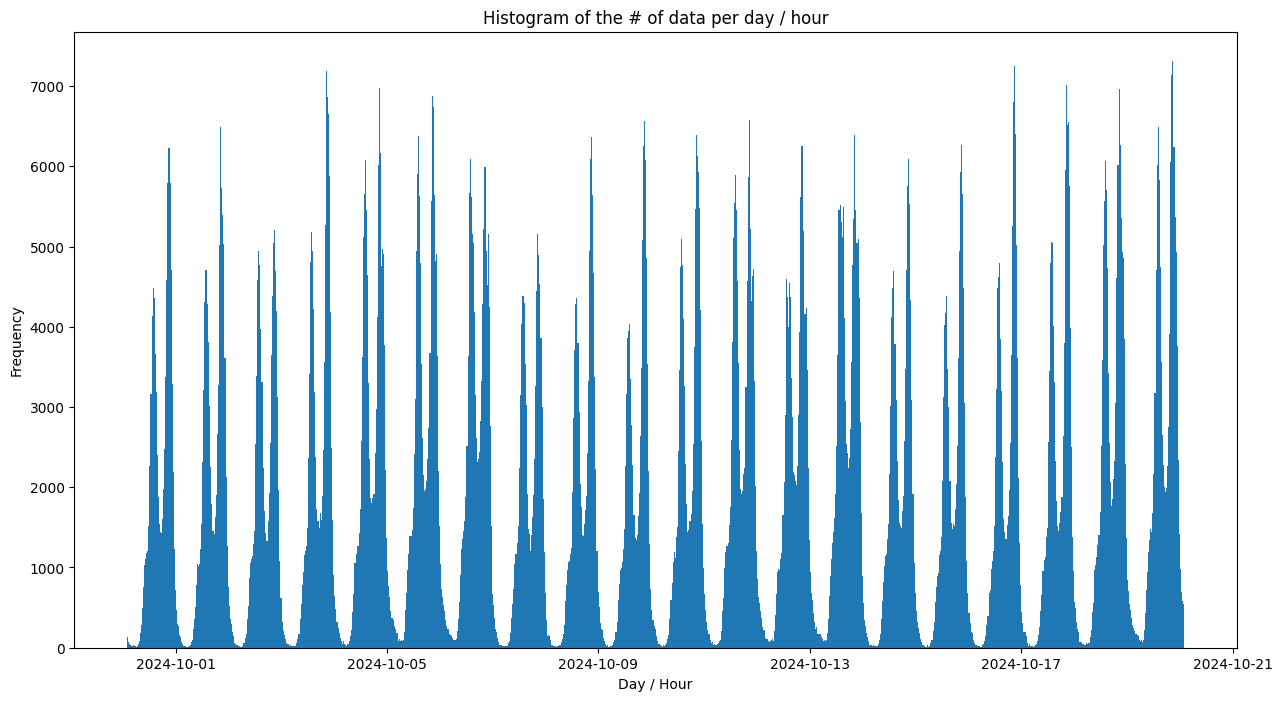

In [17]:
# Histogram of the # of data per day / hour
plt.figure(figsize=(15, 8))
plt.hist(data['creation_timestamp'], bins = 1000)
plt.title('Histogram of the # of data per day / hour')
plt.xlabel('Day / Hour')
plt.ylabel('Frequency')
plt.show()

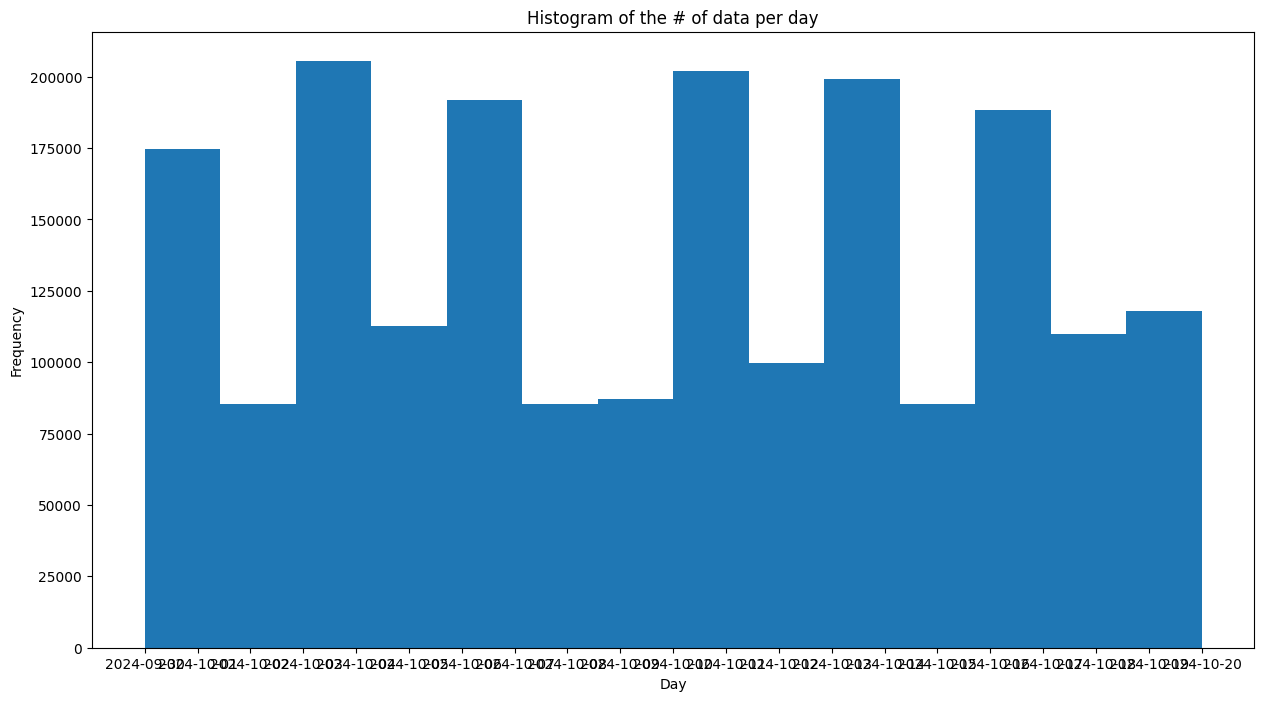

In [18]:
plt.figure(figsize=(15, 8))
plt.hist(data['creation_date'], bins = 14)
plt.title('Histogram of the # of data per day')
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.show()

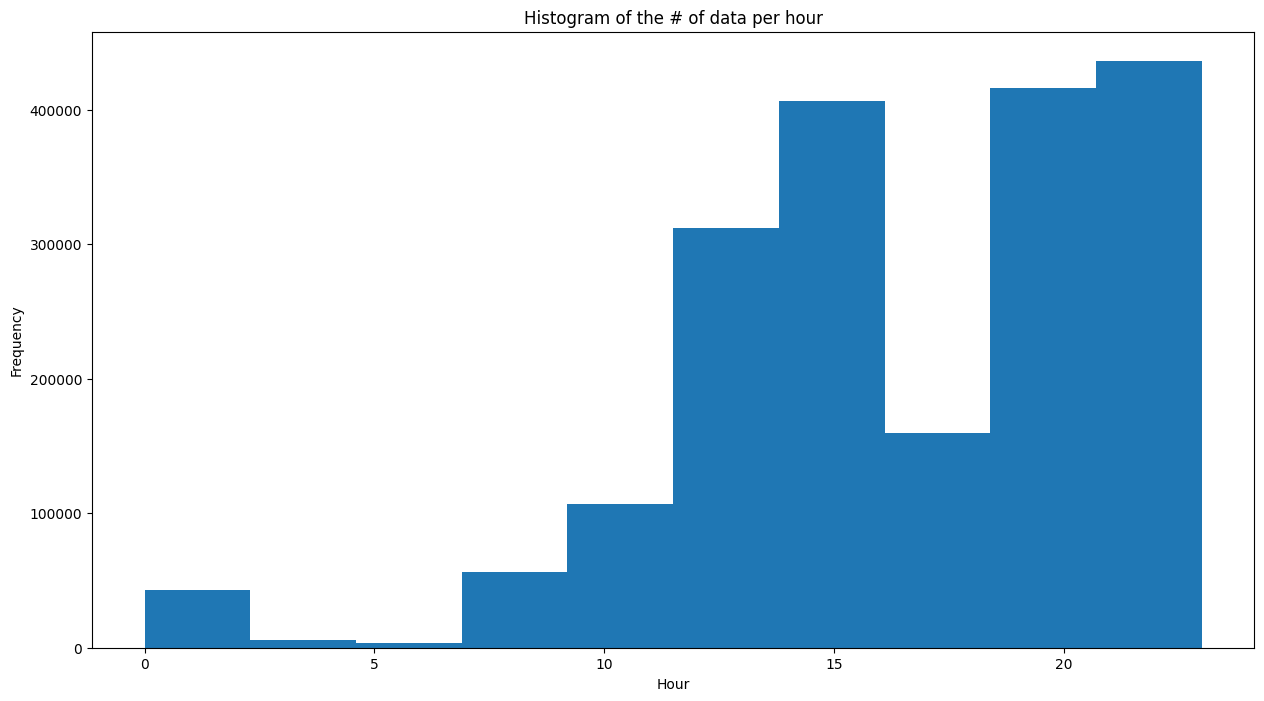

In [19]:
plt.figure(figsize=(15, 8))
plt.hist(data['creation_hour'])
plt.title('Histogram of the # of data per hour')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

In [20]:
# Check the distribution of the transport types
data['transport'].value_counts()

transport
BICYCLE      922590
MOTORBIKE    786202
CAR          235184
WALKER          966
Name: count, dtype: int64

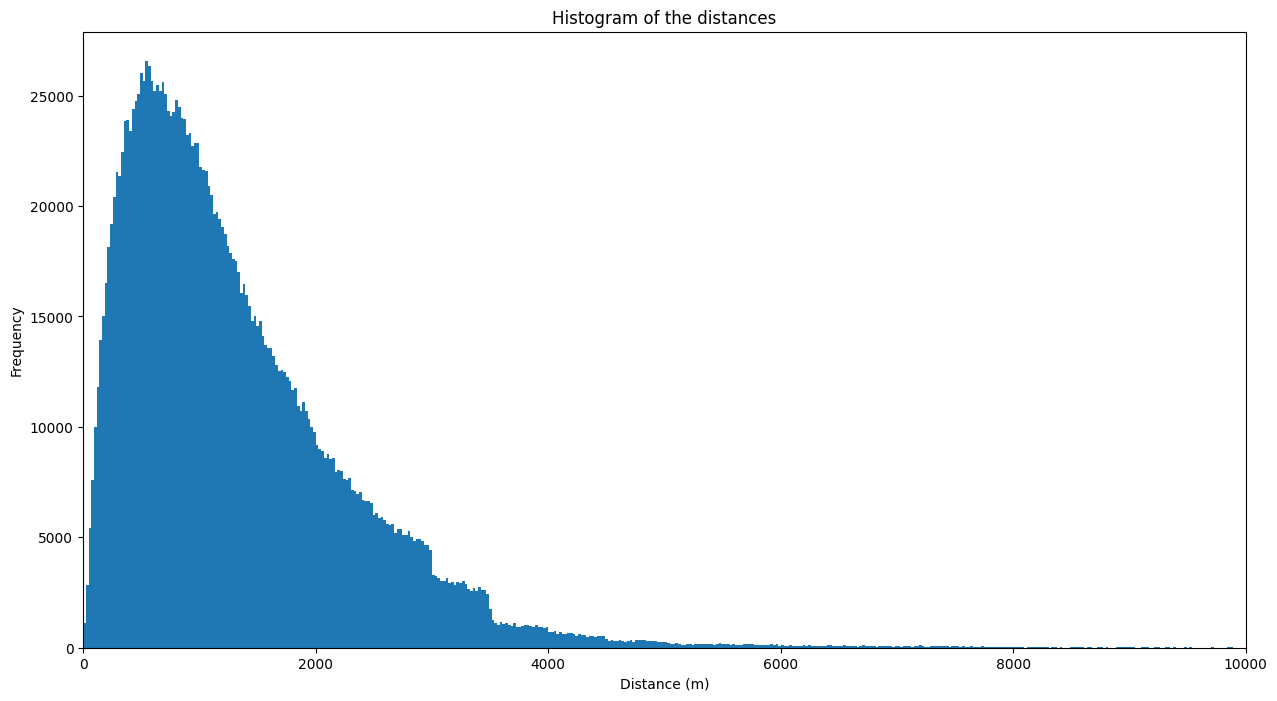

In [21]:
# Check the distribution of the distances
plt.figure(figsize=(15, 8))
plt.hist(data['pd_distance_haversine_m'], bins = 1000)
plt.xlim(0, 10000)
plt.title('Histogram of the distances')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.show()

## Hyperparameters

In [22]:
test_set_perc = 0.1
days_for_test = 7
k_cv = 5

## Database split

In [23]:
X = data
y = data['delivery_entering_timestamp'] - data['pickup_timestamp']
y = pd.Series(y, name='pickup_to_delivery')
y

19770    779000000000
19821    366918000000
19862    331825000000
19864    496886000000
19868     87720000000
             ...     
68825    150065000000
69405    558499000000
69964    742575000000
70230    786619000000
70533    194149000000
Name: pickup_to_delivery, Length: 1944942, dtype: int64

As we are dealing with a time-series dataset (orders are placed at different times), we will split the data based on the creation timestamp, leaving out the last 10% of the data for testing. This will help to understand the performance of the model on unseen data, as in reality we will have to test the model on data created on day+1 with respect to our training data.

In [24]:
X.sort_values('creation_timestamp', inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_perc, random_state=0)

In [25]:
X_train

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_timestamp,pickup_latitude,pickup_longitude,...,creation_hour,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
53889,ES,100900277932,105015393,2024-09-30 13:39:56+00:00,2024-09-30 13:39:57+00:00,BICYCLE,2024-09-30 13:49:42.061000+00:00,2024-09-30 14:01:30+00:00,41.429688,2.189959,...,13,NaN,NaN,NaN,NaN,1232.140153,74505.358603,1744.172472,2024-09-30,BCN
70130,ES,100924350624,159558961,2024-10-11 14:32:22+00:00,2024-10-11 14:32:22+00:00,BICYCLE,2024-10-11 14:41:53.789000+00:00,2024-10-11 14:56:10+00:00,40.439228,-3.696312,...,14,0.705798,-0.064513,0.705801,-0.064849,1628.337647,1628.337647,1651.729837,2024-10-11,MAD
88957,ES,100918768940,108223144,2024-10-08 19:14:04+00:00,2024-10-08 19:14:05+00:00,BICYCLE,2024-10-08 19:25:29.724000+00:00,2024-10-08 19:31:57+00:00,41.377300,2.097891,...,19,NaN,NaN,NaN,NaN,402.615391,24982.715455,569.277819,2024-10-08,BCN
4013,ES,100933843382,176973879,2024-10-15 14:07:29+00:00,2024-10-15 14:07:30+00:00,MOTORBIKE,2024-10-15 14:14:04.332000+00:00,2024-10-15 14:19:40+00:00,41.429756,2.161242,...,14,NaN,NaN,NaN,NaN,405.944675,23382.745650,484.022589,2024-10-15,BCN
13618,ES,100903345651,54241613,2024-10-01 21:05:21+00:00,2024-10-01 21:05:22+00:00,BICYCLE,2024-10-01 21:14:43.972000+00:00,2024-10-01 21:28:05+00:00,41.388300,2.140600,...,21,NaN,NaN,NaN,NaN,1739.745655,103623.455589,2389.313273,2024-10-01,BCN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52473,ES,100903301229,8047290,2024-10-01 20:51:35+00:00,2024-10-01 20:51:37+00:00,CAR,2024-10-01 20:59:18.960000+00:00,2024-10-01 21:08:45+00:00,40.439373,-3.622343,...,20,0.705800,-0.063222,0.705703,-0.062980,1323.654237,1323.654237,1790.127336,2024-10-01,MAD
20076,ES,100922036918,74737414,2024-10-10 13:31:25+00:00,2024-10-10 13:31:27+00:00,MOTORBIKE,2024-10-10 13:44:50.729000+00:00,2024-10-10 13:51:36+00:00,40.479706,-3.707206,...,13,0.706504,-0.064703,0.706489,-0.064643,305.680635,305.680635,385.123128,2024-10-10,MAD
84994,ES,100902409871,147457017,2024-10-01 14:54:44+00:00,2024-10-01 14:54:45+00:00,BICYCLE,2024-10-01 15:01:14.898000+00:00,2024-10-01 15:12:48+00:00,41.384686,2.168798,...,14,NaN,NaN,NaN,NaN,1396.602242,83060.423915,1918.427079,2024-10-01,BCN
90858,ES,100934320697,88290470,2024-10-15 17:45:43+00:00,2024-10-15 17:45:45+00:00,BICYCLE,2024-10-15 17:58:03.741000+00:00,2024-10-15 18:10:37+00:00,41.398815,2.172954,...,17,0.722546,0.037925,0.722225,0.037800,2126.279603,2126.279603,2641.752121,2024-10-15,BCN


In [26]:
y_train

52085    427431000000
652      311913000000
71799    530023000000
48642    538957000000
67928    317986000000
             ...     
42893    415733000000
96394    198415000000
50159    657688000000
90902    286079000000
95895    360789000000
Name: pickup_to_delivery, Length: 1750447, dtype: int64

In [27]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1750447, 26) (1750447,)
(194495, 26) (194495,)


In [28]:
# In case we want to test different hyperparameters, we will use cross-validation
#scores = cross_val_score(<estimator>, X, y, cv=k_cv)

### Database split using directly the creation date

As we have partitioned the data by city and creation date, we can use this information to split the data. This will help to avoid data leakage, as we will not have data from the future in the training set.
This is much better than just sorting the data by the creation timestamp and taking 10% of the dataset as test set, as we did before.

In [29]:
# We take the last week of the dataset to test the model
begin_test_date = pd.to_datetime(end_date) - pd.Timedelta(days=days_for_test-1)
begin_test_date = begin_test_date.strftime("%Y-%m-%d")
print(f'Start date: {start_date} | Begin test date: {begin_test_date} | End date: {end_date}')

Start date: 2024-09-30 | Begin test date: 2024-10-14 | End date: 2024-10-20


In [30]:
X_train = pd.read_parquet("data/dataframe.parquet", filters=[('creation_date', '<', begin_test_date)])
X_train.head()

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_timestamp,pickup_latitude,pickup_longitude,...,creation_hour,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
19770,ES,100899883502,166015865,2024-09-30 10:05:31+00:00,2024-09-30 10:05:34+00:00,CAR,2024-09-30 10:40:49+00:00,2024-09-30 10:55:21+00:00,38.354984,-0.470788,...,10,0.669421,-0.008217,0.669275,-0.008738,2763.186813,2763.186813,3533.822837,2024-09-30,ALC
19821,ES,100900284118,157369264,2024-09-30 13:42:20+00:00,2024-09-30 13:42:21+00:00,MOTORBIKE,2024-09-30 13:51:19.082000+00:00,2024-09-30 14:08:16+00:00,38.338870,-0.516630,...,13,0.669140,-0.009017,0.669173,-0.008800,1106.367198,1106.367198,1302.313007,2024-09-30,ALC
19862,ES,100900514765,176279014,2024-09-30 15:15:51+00:00,2024-09-30 15:15:53+00:00,MOTORBIKE,2024-09-30 15:40:37.175000+00:00,2024-09-30 15:46:54+00:00,38.391617,-0.513310,...,15,0.670060,-0.008959,0.670198,-0.009175,1391.554868,1391.554868,1959.883768,2024-09-30,ALC
19864,ES,100900517471,173230048,2024-09-30 15:17:03+00:00,2024-09-30 15:17:04+00:00,MOTORBIKE,2024-09-30 15:38:09.114000+00:00,2024-09-30 15:55:25+00:00,38.428850,-0.394868,...,15,0.670710,-0.006892,0.670976,-0.007713,4433.090322,4433.090322,5796.876236,2024-09-30,ALC
19868,ES,100900606611,165214923,2024-09-30 15:59:24+00:00,2024-09-30 15:59:26+00:00,CAR,2024-09-30 16:09:12.280000+00:00,2024-09-30 16:11:30+00:00,38.344795,-0.484257,...,15,0.669243,-0.008452,0.669260,-0.008486,203.358663,203.358663,281.024598,2024-09-30,ALC


In [31]:
y_train = X_train['delivery_entering_timestamp'] - X_train['pickup_timestamp']
y = pd.Series(y, name='pickup_to_delivery')
y

19770    779000000000
19821    366918000000
19862    331825000000
19864    496886000000
19868     87720000000
             ...     
68825    150065000000
69405    558499000000
69964    742575000000
70230    786619000000
70533    194149000000
Name: pickup_to_delivery, Length: 1944942, dtype: int64

In [32]:
X_test = pd.read_parquet("data/dataframe.parquet", filters=[('creation_date', '>=', begin_test_date)])
X_test.head()

,country_code,order_id,courier_id,creation_timestamp,activation_timestamp,transport,pickup_timestamp,delivery_timestamp,pickup_latitude,pickup_longitude,...,creation_hour,pickup_latitude_rad,pickup_longitude_rad,delivery_latitude_rad,delivery_longitude_rad,pd_distance_haversine_m,pd_distance_haversine_m_sk,pd_distance_manhattan_m,creation_date,city_code
4718,ES,100932167582,10191824,2024-10-14 15:51:51+00:00,2024-10-14 15:51:52+00:00,MOTORBIKE,2024-10-14 16:00:14.017000+00:00,2024-10-14 16:08:56+00:00,38.360110,-0.496079,...,15,0.669510,-0.008658,0.669291,-0.008891,1817.533836,1817.533836,2562.964399,2024-10-14,ALC
4727,ES,100932256816,50618208,2024-10-14 16:36:30+00:00,2024-10-14 16:36:31+00:00,CAR,2024-10-14 16:45:53.061000+00:00,2024-10-14 16:56:21+00:00,38.354233,-0.472088,...,16,0.669408,-0.008239,0.669490,-0.008349,757.291206,757.291206,1071.856530,2024-10-14,ALC
4746,ES,100932496959,170202435,2024-10-14 18:26:33+00:00,2024-10-14 18:26:34+00:00,MOTORBIKE,2024-10-14 18:35:05.220000+00:00,2024-10-14 18:43:20+00:00,38.429874,-0.400611,...,18,0.670728,-0.006992,0.670951,-0.006570,2541.011986,2541.011986,3531.016499,2024-10-14,ALC
4767,ES,100932664161,166731686,2024-10-14 19:30:57+00:00,2024-10-14 19:30:59+00:00,CAR,2024-10-14 19:58:06.210000+00:00,2024-10-14 20:04:48+00:00,38.398090,-0.432838,...,19,0.670173,-0.007554,0.670373,-0.007686,1432.008005,1432.008005,1931.872080,2024-10-14,ALC
4794,ES,100932854728,168741567,2024-10-14 20:35:29+00:00,2024-10-14 20:35:30+00:00,CAR,2024-10-14 20:57:11.030000+00:00,2024-10-14 21:04:55+00:00,38.355713,-0.479695,...,20,0.669433,-0.008372,0.669508,-0.008358,477.653498,477.653498,544.529748,2024-10-14,ALC


In [33]:
y_test
y = X_test['delivery_entering_timestamp'] - X_test['pickup_timestamp']
y = pd.Series(y, dtype=np.int64, name='pickup_to_delivery')
y

4718     400983000000
4727     482939000000
4746     386780000000
4767     324790000000
4794     184970000000
             ...     
68825    150065000000
69405    558499000000
69964    742575000000
70230    786619000000
70533    194149000000
Name: pickup_to_delivery, Length: 588906, dtype: int64

In [34]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1356036, 26) (1356036,)
(588906, 26) (194495,)


Compute the column for velocity 

In [35]:
velocity = X_train['pd_distance_haversine_m'] / y_train.dt.total_seconds()
velocity

19770    3.547095
19821    3.015298
19862    4.193641
19864    8.921745
19868    2.318270
           ...   
84190    3.829951
84192    2.854189
84663    3.992609
85111    3.630421
85969    5.106117
Length: 1356036, dtype: float64